## Time-series modeling 
We create a time series model for the Land-Ocean Temperature Index (LOTI). 
We evaluate different configurations for a SARIMAX (seasonal autoregressive integrated moving average) model using grid search, with mean squared error as a performance metric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set_context('notebook', font_scale=1.2)

In [40]:
# wrapper for statsmodels SARIMAX model to make it compatible with the scikit-learn API
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    """Sklearn wrapper for statsmodels SARIMAX models"""
    def __init__(self, 
                 order=(1, 0, 0), 
                 seasonal_order=(0, 0, 0, 0), 
                 trend=None, 
                 measurement_error=False, 
                 time_varying_regression=False, 
                 mle_regression=True, 
                 simple_differencing=False, 
                 enforce_stationarity=True, 
                 enforce_invertibility=True, 
                 hamilton_representation=False, 
                 concentrate_scale=False,
                 freq=None):
        self.SARIMAX = sm.tsa.SARIMAX
        self.order = order
        self.seasonal_order = seasonal_order
        self.trend = trend
        self.measurement_error = measurement_error
        self.enforce_stationarity = enforce_stationarity
        self.enforce_invertibility = enforce_invertibility
        self.freq = freq
        
    def fit(self, X, y=None):
        self.model_ = self.SARIMAX(endog=X,  
                                   order=self.order, 
                                   seasonal_order=self.seasonal_order,
                                   trend=self.trend,
                                   measurement_error=self.measurement_error,
                                   enforce_stationarity=self.enforce_stationarity,
                                   enforce_invertibility=self.enforce_invertibility,
                                   freq=self.freq)
        try:
            self.results_ = self.model_.fit(method='powell')
        except ValueError as error:
            print(self.order, error)
    
    def predict(self, X):
        return self.results_.forecast(len(X))

In [3]:
monthly_deviations = pd.read_csv('../data/NASA_GISS_LOTI_long_format.csv', 
                                 index_col='Date', 
                                 parse_dates=['Date'])

In [4]:
# take deviations from mean up to (and including) 2019-01
global_deviations = monthly_deviations['global']
northern_deviations = monthly_deviations['northern']

There is a clear upward trend and some seasonality in both time-series, thus they are most likely not stationary.

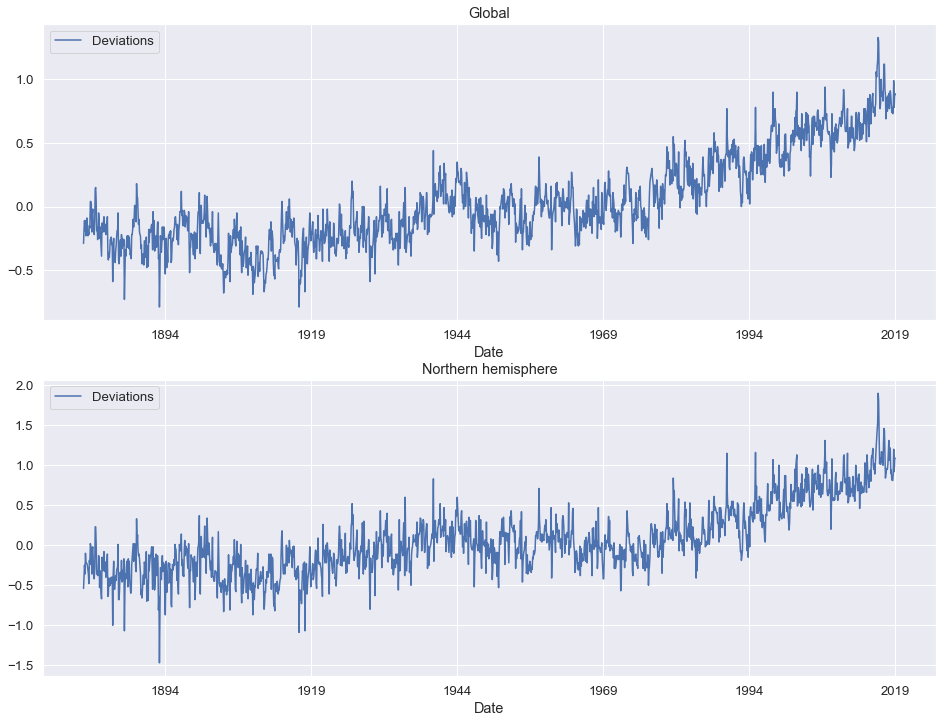

In [5]:
# plot time series
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 12))

global_deviations.plot(ax=ax1, title='Global', label='Deviations')
northern_deviations.plot(ax=ax2, title='Northern hemisphere', label='Deviations')
_ = ax1.legend()
_ = ax2.legend()

### Time series modeling

In [6]:
# split data set into training and validation sets
# we leave the last 12 months for validation
n_test = 12
n_train = global_deviations.shape[0] - n_test

gld_train = global_deviations.iloc[:n_train]
gld_test = global_deviations.iloc[n_train:]

nhd_train = northern_deviations.iloc[:n_train]
nhd_test = northern_deviations.iloc[n_train:]

We test for a unit root using the Augmented Dickey-Fuller (ADF) test. The null hypothesis is that the time-series has a unit root, which implies that it is non-stationary. We allow for a constant and linear term in the regression model, the maximum number of lags is chosen using the Akaike information criterion. The test is performed at significance level $\alpha = 0.01$.

The null hypothesis can not be rejected for either time-series.

In [7]:
print("Augmented Dickey-Fuller test", 
      "Global: p-value = {:.6f}".format(sm.tsa.adfuller(gld_train, regression='ct', autolag='AIC')[1]),
      "Northern: p-value = {:.6f}".format(sm.tsa.adfuller(nhd_train, regression='ct', autolag='AIC')[1]), sep='\n')

Augmented Dickey-Fuller test
Global: p-value = 0.023917
Northern: p-value = 0.102194


The previous plots and the results form the ADF test suggests that the series are not stationary.
We take the first differences to try to make the series stationary.

In [8]:
# calculate first differences and discard first observation (which is NaN after differencing)
gld_train_diff = gld_train.diff(1)[1:]
nhd_train_diff = nhd_train.diff(1)[1:]

The plot of the differenced time-series looks much more closer to a stationary process. Thus it seems reasonable to use first (or higher) order differences in the model. In the ADF test we can also reject the null hypothesis of an unit root.

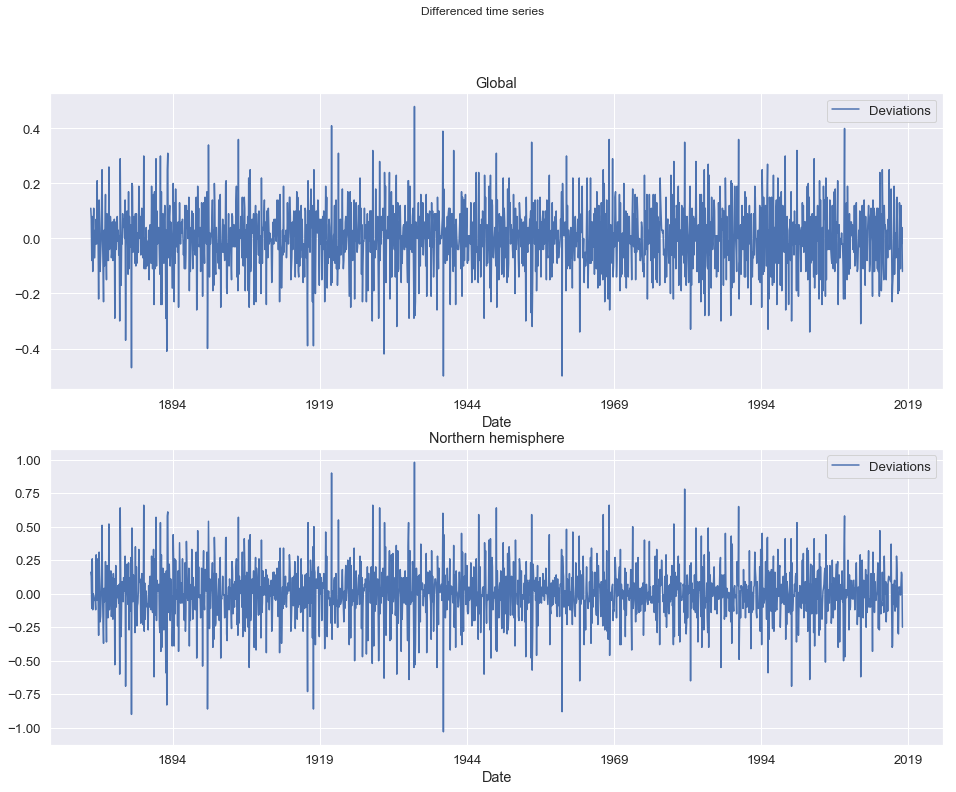

In [9]:
# plot differenced time series
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 12))

gld_train_diff.plot(ax=ax1, title='Global', label='Deviations')
nhd_train_diff.plot(ax=ax2, title='Northern hemisphere', label='Deviations')
ax1.legend()
ax2.legend()
_ = plt.suptitle('Differenced time series')

In [13]:
print("Augmented Dickey-Fuller test", 
      "Global: p-value = {:.6f}".format(sm.tsa.adfuller(gld_train_diff, regression='c', autolag='AIC')[1]),
      "Northern: p-value = {:.6f}".format(sm.tsa.adfuller(nhd_train_diff, regression='c', autolag='AIC')[1]), sep='\n')

Augmented Dickey-Fuller test
Global: p-value = 0.000000
Northern: p-value = 0.000000


The autocorrelation function (ACF) and partial autocorrelation function (PACF) are calculated and plotted below, to get and idea of what order the model parameters could be.

For the Global deviations time-series:
Since the coefficients in the PACF seems to die out after the $6$:th lag, we choose to use 6 as the upper limit for the auto-regressive (AR) order $p$. The ACF suggests a moving average (MA) order of $1$. We attribute "significant" coefficients at higher lags to random variations in the data.

For the Northern hemisphere deviations time-series:
The PACF suggests a maximum AR order of $11$, and the ACF a maximum MA order of $1$.

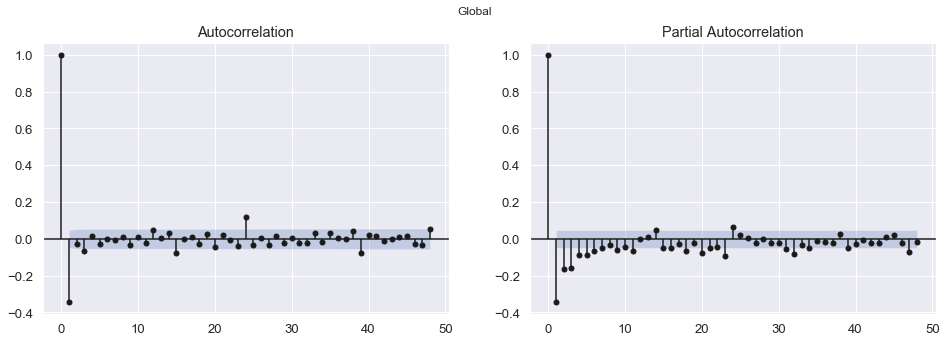

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

nlags = 48

_ = plot_acf(gld_train_diff, lags=nlags, color='k', ax=ax1)
_ = plot_pacf(gld_train_diff, lags=nlags, color='k', ax=ax2)
_ = plt.suptitle('Global')

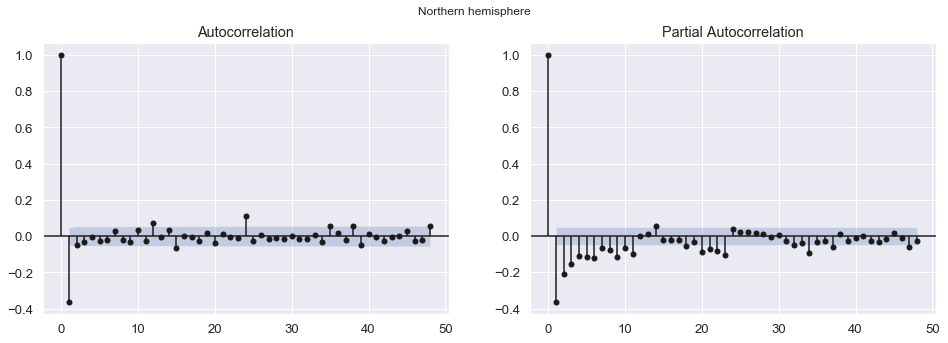

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

_ = plot_acf(nhd_train_diff, lags=nlags, color='k', ax=ax1)
_ = plot_pacf(nhd_train_diff, lags=nlags, color='k', ax=ax2)
_ = plt.suptitle('Northern hemisphere')

Using the observations from the ACF and PACF we create the possible configurations for our model.
The a grid search is performed over the different configurations. The models are cross-validated using time series cross-validation which preserves the order relations of the data so that the model is always trained on historical data and tested on more recent "unseen" data.

In [41]:
model = SARIMAXWrapper()

# we keep the seasonal orders at a fixed configuration. 
# The last parameter m = 12 indicates number of time steps for a single seasonal period.
# We assume that one season is a year (12 months)

grid = GridSearchCV(model,
                    param_grid={
                        'order': [
                            (1, 1, 1), 
                            (2, 1, 1), 
                            (3, 1, 1), 
                            (4, 1, 1), 
                            (5, 1, 1), 
                            (6, 1, 1)
                        ],
                        'seasonal_order': [(1, 1, 1, 12),],
                        'trend': ['ct',],
                        'freq': ['MS'],
                    },
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=3), 
                    n_jobs=1,
                    verbose=3)

grid.fit(gld_train, gld_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 
Optimization terminated successfully.
         Current function value: -0.742669
         Iterations: 8
         Function evaluations: 684
[CV]  freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-3.68974489998396, total=   5.2s
[CV] freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


Optimization terminated successfully.
         Current function value: -0.758620
         Iterations: 7
         Function evaluations: 617
[CV]  freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.25454713473413226, total=   8.6s
[CV] freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


Optimization terminated successfully.
         Current function value: -0.767547
         Iterations: 7
         Function evaluations: 609
[CV]  freq=MS, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.02140465376524079, total=  12.5s
[CV] freq=MS, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 
Optimization terminated successfully.
         Current function value: -0.743569
         Iterations: 8
         Function evaluations: 784
[CV]  freq=MS, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-6.6941828477702385, total=   6.5s
[CV] freq=MS, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 
Optimization terminated successfully.
         Current function value: -0.758453
         Iterations: 7
         Function evaluations: 666
[CV]  freq=MS, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-1.2958084541922872, total=  10.4s
[CV] freq=MS, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct 
Optimization terminated succes

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.3min finished


Optimization terminated successfully.
         Current function value: -0.779570
         Iterations: 21
         Function evaluations: 2294


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq=None, hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(1, 0, 0),
        seasonal_order=(0, 0, 0, 0), simple_differencing=None,
        time_varying_regression=None, trend=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'order': [(1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (6, 1, 1)], 'seasonal_order': [(1, 1, 1, 12)], 'trend': ['ct'], 'freq': ['MS']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [42]:
print("Best model found through grid search:")
display(grid.best_estimator_)
print("MSE of best model: {:.4f}".format(- grid.best_score_))

Best model found through grid search:


SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(3, 1, 1),
        seasonal_order=(1, 1, 1, 12), simple_differencing=None,
        time_varying_regression=None, trend='ct')

MSE of best model: 0.0645


Take the model with the best parameter configuration.

In [43]:
gld_model_fit = grid.best_estimator_.results_

In [44]:
display(gld_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             global   No. Observations:                 1657
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1291.748
Date:                            Mon, 04 Mar 2019   AIC                          -2565.496
Time:                                    12:25:05   BIC                          -2516.852
Sample:                                01-01-1880   HQIC                         -2547.458
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.037e-06   6.97e-06      0.436      0.663   -1.06e-05    1.67e-05
drift       1.852e-09   7.92e-09      0.234      0.815   -1.37e-08    1.74e-08
ar.L1          0.4812      0.023     20.729      0.000       0.436       0.527
ar.L2          0.1764      0.027      6.639      0.000       0.124       0.228
ar.L3          0.0818      0.025      3.266      0.001       0.033       0.131
ma.L1         -0.9832      0.006   -161.218      0.000      -0.995      -0.971
ar.S.L12       0.0241      0.023      1.056      0.291      -0.021       0.069
ma.S.L12      -0.9603      0.008   -123.065      0.000      -0.976      -0.945
sigma2         0.0119      0.000     33.993      0.000       0.011       0.013
===================================================================================
Ljung-Box (Q):                       55.15   Jarque-Bera (JB):                47.51
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.00
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check adequacy of the model by creating a QQ-plot and kernerl density plot for the residuals.
Residuals seems to be close to normally distributed, although the QQ-plot indicates that the tails are somewhat fatter than would be typical for normally distributed values.

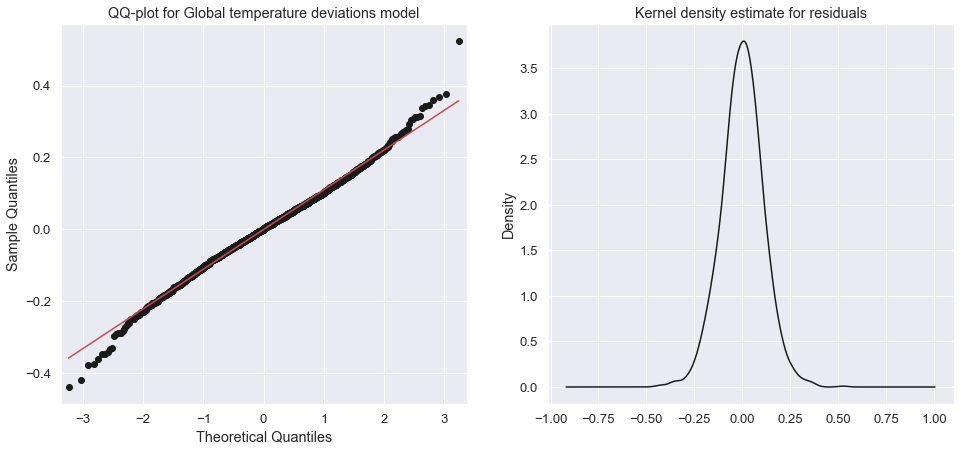

In [45]:
gld_model_resid = pd.Series(gld_model_fit.resid)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
_ = sm.qqplot(gld_model_resid, line='s', color='k', ax=ax1)
_ = ax1.set_title('QQ-plot for Global temperature deviations model')

gld_model_resid.plot(kind='kde', ax=ax2, color='k', title='Kernel density estimate for residuals')

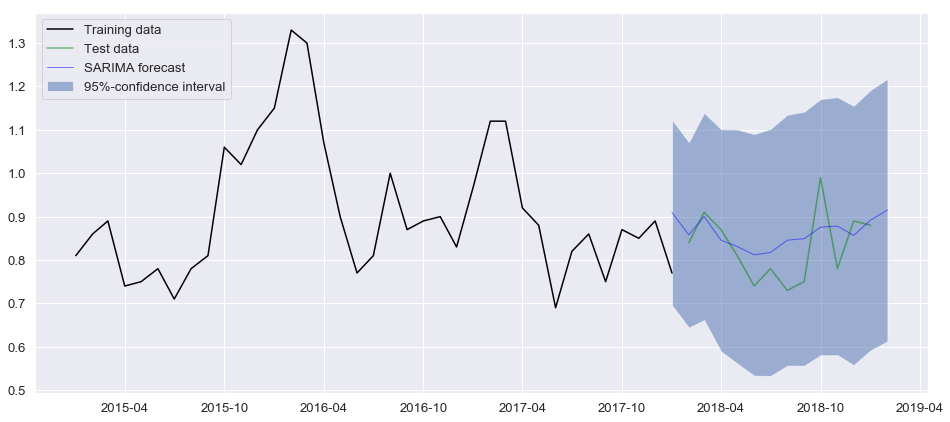

In [46]:
pred_res = gld_model_fit.get_prediction(start='2018-01-01', end='2019-02-01', 
                                        full_results=True, alpha=0.05)

pred_means = pred_res.predicted_mean

# alpha = 0.05 => 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot('111')

# actual data
ax.plot(gld_train['2015':], color="black", label='Training data')
ax.plot(gld_test, color="green", alpha=0.5, label='Test data')

# means
ax.plot(pred_means, lw=1, color="blue", alpha=0.5, label='SARIMA forecast')
ax.fill_between(pred_means.index, pred_cis.iloc[:, 0], pred_cis.iloc[:, 1], alpha=0.5, label='95%-confidence interval')
ax.legend(loc='upper left')
plt.draw()

In [48]:
model = SARIMAXWrapper(freq='MS')

grid = GridSearchCV(model, 
                    param_grid={
                        'order': [
                            (1, 1, 1),
                            (2, 1, 1),
                            (3, 1, 1),
                            (4, 1, 1),
                            (5, 1, 1),
                            (6, 1, 1),
                            (7, 1, 1),
                            (8, 1, 1),
                            (9, 1, 1),
                            (10, 1, 1),
                            (11, 1, 1)
                        ],
                        'seasonal_order': [(1, 1, 1, 12)],
                        'trend': ['ct'],
                        'freq': ['MS'],
                    },
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=3), 
                    n_jobs=1,
                    verbose=3)

grid.fit(nhd_train, nhd_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........
Optimization terminated successfully.
         Current function value: -0.159935
         Iterations: 17
         Function evaluations: 1498
[CV]  order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.10406222374401303, total=  11.0s
[CV] order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


Optimization terminated successfully.
         Current function value: -0.190176
         Iterations: 7
         Function evaluations: 604
[CV]  order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.6000134440953363, total=   8.5s
[CV] order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


Optimization terminated successfully.
         Current function value: -0.226822
         Iterations: 7
         Function evaluations: 604
[CV]  order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.09335121147059093, total=  12.5s
[CV] order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........
Optimization terminated successfully.
         Current function value: -0.158055
         Iterations: 10
         Function evaluations: 977
[CV]  order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.06823759373000074, total=   7.1s
[CV] order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........
Optimization terminated successfully.
         Current function value: -0.190422
         Iterations: 7
         Function evaluations: 688
[CV]  order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.8866900141207671, total=   9.7s
[CV] order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct .........
Optimization terminated successfully.
         Current 

Optimization terminated successfully.
         Current function value: -0.187308
         Iterations: 7
         Function evaluations: 1288
[CV]  order=(10, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.9389845746354434, total=  31.9s
[CV] order=(10, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct ........
Optimization terminated successfully.
         Current function value: -0.224680
         Iterations: 8
         Function evaluations: 1484
[CV]  order=(10, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-0.2082138434759405, total=  54.7s
[CV] order=(11, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct ........
Optimization terminated successfully.
         Current function value: -0.168284
         Iterations: 30
         Function evaluations: 6077
[CV]  order=(11, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct, score=-1.0765304075393642, total= 1.2min
[CV] order=(11, 1, 1), seasonal_order=(1, 1, 1, 12), trend=ct ........
Optimization terminated successfully.
         Curr

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 22.4min finished


Optimization terminated successfully.
         Current function value: -0.267435
         Iterations: 22
         Function evaluations: 3905


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(1, 0, 0),
        seasonal_order=(0, 0, 0, 0), simple_differencing=None,
        time_varying_regression=None, trend=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'order': [(1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (6, 1, 1), (7, 1, 1), (8, 1, 1), (9, 1, 1), (10, 1, 1), (11, 1, 1)], 'seasonal_order': [(1, 1, 1, 12)], 'trend': ['ct']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [49]:
print("Best model found through grid search:")
display(grid.best_estimator_)
print("MSE of best model: {:.4f}".format(- grid.best_score_))

Best model found through grid search:


SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(9, 1, 1),
        seasonal_order=(1, 1, 1, 12), simple_differencing=None,
        time_varying_regression=None, trend='ct')

MSE of best model: 0.2303


In [50]:
nhd_model_fit = grid.best_estimator_.results_

In [51]:
display(nhd_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           northern   No. Observations:                 1657
Model:             SARIMAX(9, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 443.140
Date:                            Mon, 04 Mar 2019   AIC                           -856.280
Time:                                    16:09:51   BIC                           -775.207
Sample:                                01-01-1880   HQIC                          -826.216
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.047e-06   1.17e-05     -0.344      0.730   -2.71e-05     1.9e-05
drift        1.23e-08   1.38e-08      0.894      0.371   -1.47e-08    3.93e-08
ar.L1          0.3855      0.021     18.243      0.000       0.344       0.427
ar.L2          0.1272      0.025      5.116      0.000       0.078       0.176
ar.L3          0.0626      0.028      2.237      0.025       0.008       0.117
ar.L4          0.0431      0.033      1.314      0.189      -0.021       0.107
ar.L5          0.0067      0.034      0.196      0.845      -0.060       0.073
ar.L6          0.0315      0.039      0.817      0.414      -0.044       0.107
ar.L7          0.0474      0.036      1.310      0.190      -0.023       0.118
ar.L8         -0.0061      0.034     -0.179      0.858      -0.073       0.061
ar.L9          0.0016      0.028      0.055      0.956      -0.054       0.057
ma.L1         -0.9866      0.006   -164.656      0.000      -0.998      -0.975
ar.S.L12       0.0264      0.021      1.246      0.213      -0.015       0.068
ma.S.L12      -0.9419      0.009   -107.217      0.000      -0.959      -0.925
sigma2         0.0335      0.001     37.992      0.000       0.032       0.035
===================================================================================
Ljung-Box (Q):                       48.52   Jarque-Bera (JB):               192.57
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check adequacy of the model by creating a QQ-plot and kernerl density plot for the residuals.

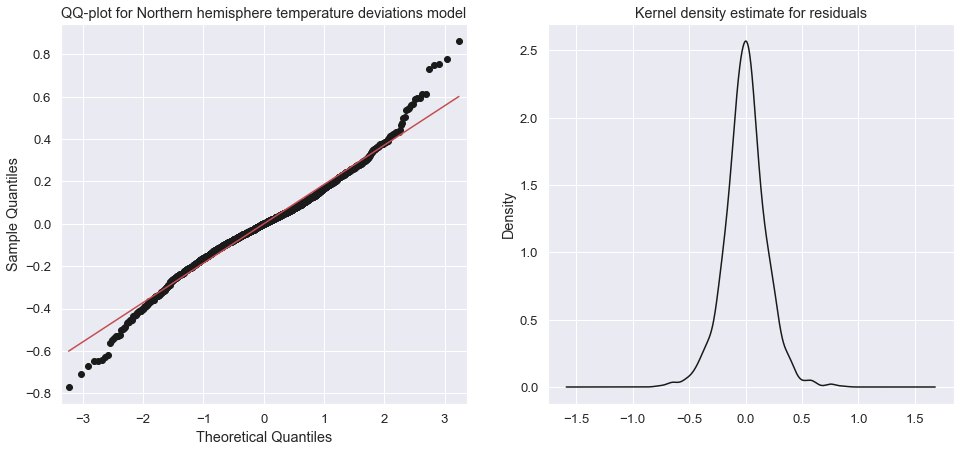

In [52]:
nhd_model_resid = pd.Series(nhd_model_fit.resid)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
_ = sm.qqplot(nhd_model_resid, line='s', color='k', ax=ax1)
_ = ax1.set_title('QQ-plot for Northern hemisphere temperature deviations model')
_ = nhd_model_resid.plot(kind='kde', ax=ax2, color='k', title='Kernel density estimate for residuals')

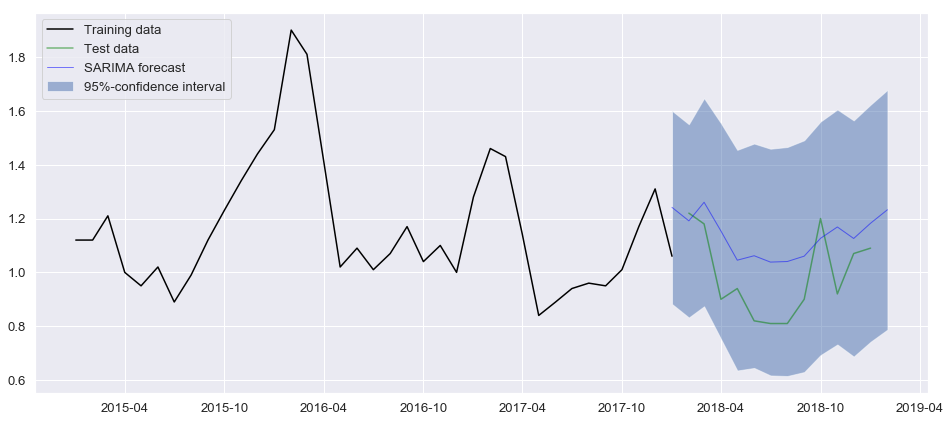

In [53]:
# plot forecast fit 95% CI and compare to actual test data
pred_res = nhd_model_fit.get_prediction(start='2018-01-01', end='2019-02-01', 
                                        full_results=True, alpha=0.05)

pred_means = pred_res.predicted_mean

# alpha = 0.05 => 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot('111')

# plot training data from 2010 and forward
ax.plot(nhd_train['2015':], color="black", label='Training data')
# plot test data
ax.plot(nhd_test, color="green", alpha=0.5, label='Test data')

# means
ax.plot(pred_means, lw=1, color="blue", alpha=0.5, label='SARIMA forecast')
ax.fill_between(pred_means.index, pred_cis.iloc[:, 0], pred_cis.iloc[:, 1], alpha=0.5, label='95%-confidence interval')
ax.legend(loc='upper left')
plt.draw()